## TEXT MINING

In [638]:
import os
import csv
from tqdm import tqdm # Tracking loading progress
tqdm.pandas()
# Preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
#nltk.download('stopwords')
from nltk.corpus import stopwords # Add MODERATOR TO THE STOPWORDS LIST
#!python -m spacy download en_core_web_sm
import spacy
import pickle
sp = spacy.load('en_core_web_sm')
#Regex
import re
#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
#Text Mining & Dimensionality Reduction
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,LatentDirichletAllocation
import pandas as pd
import numpy as np
import ast
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import prepr_functions
from prepr_functions import *

In [639]:
#Get path
current_directory = os.getcwd()
current_directory

'/Users/mikelgallo/repos2/pga_liv'

## Loading data


In [640]:
df = pd.read_csv(current_directory+'/datasets/df_clean.csv')

In [641]:
df.head()

,player,LIV_Player,year_month,year,answer_length,PGA,LIV,relevant,question,reply_sentence,LIV_CHANGE
0,rory mcilroy,0,2024-02,2024,111,1,0,1,third start this season had a chance to play p...,yeah so third start on the pga tour i had two ...,0
1,rory mcilroy,0,2024-02,2024,7,0,1,1,he started by saying there is a good chance yo...,somewhere in the middle maybe who knows,0
2,rory mcilroy,0,2024-01,2024,6,0,1,1,but do you think that it's also reflective of ...,just buy sky sports i guess,0
3,rory mcilroy,0,2024-01,2024,129,1,0,1,i can't help asking about asia this year proba...,absolutely i spoke to dr munjal on the course ...,0
4,rory mcilroy,0,2024-01,2024,146,0,1,1,you have that wonderful privilege of going bac...,yeah it was obviously the first win of my prof...,0


## Preprocessing

In [642]:
## Preprocesing both interviews and questions
df['prepro_interviews'] = txtprocess_tok(df,'reply_sentence',2)
df['prepro_questions'] = txtprocess_tok(df,'question',2)

df = df[['player','LIV_Player','year_month','year','answer_length','PGA','LIV','question','reply_sentence','prepro_interviews','prepro_questions','LIV_CHANGE']]


100%|██████████| 1571/1571 [00:10<00:00, 148.74it/s]


In [643]:
## Concatenate question*2 + answer after preprocessing

df['two_question_text']=df['prepro_interviews']+' '+df['prepro_questions']+' '+df['prepro_questions']
df.head()

,player,LIV_Player,year_month,year,answer_length,PGA,LIV,question,reply_sentence,prepro_interviews,prepro_questions,LIV_CHANGE,two_question_text
0,rory mcilroy,0,2024-02,2024,111,1,0,third start this season had a chance to play p...,yeah so third start on the pga tour i had two ...,yeah third start pga tour two event middle eas...,third start season chance play pebble genesis ...,0,yeah third start pga tour two event middle eas...
1,rory mcilroy,0,2024-02,2024,7,0,1,he started by saying there is a good chance yo...,somewhere in the middle maybe who knows,somewhere middle maybe know,start say good chance would go liv percentage,0,somewhere middle maybe know start say good cha...
2,rory mcilroy,0,2024-01,2024,6,0,1,but do you think that it's also reflective of ...,just buy sky sports i guess,buy sky sport guess,think also reflective attitude debate fact say...,0,buy sky sport guess think also reflective atti...
3,rory mcilroy,0,2024-01,2024,129,1,0,i can't help asking about asia this year proba...,absolutely i spoke to dr munjal on the course ...,absolutely speak dr munjal course today know g...,help ask asia year probably dp world tour one ...,0,absolutely speak dr munjal course today know g...
4,rory mcilroy,0,2024-01,2024,146,0,1,you have that wonderful privilege of going bac...,yeah it was obviously the first win of my prof...,yeah obviously first win professional career f...,wonderful privilege go back golf course win qu...,0,yeah obviously first win professional career f...


### Creating a dataframe copy

In [644]:
df_nlp = df.copy()

### Pipeline definition and training

In [645]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mikelgallo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mikelgallo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mikelgallo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [646]:
pipeline = Pipeline([
    ("vect", CountVectorizer(ngram_range=(1, 3), min_df=0.05, max_df=0.99)),
    ("tfidf", TfidfTransformer(use_idf=True, norm='l1')),
])

# Fit the pipeline to the validation data
pipeline.fit(df_nlp['two_question_text'])

# Transform the validation data using the fitted pipeline
validation_tfidf = pipeline.transform(df_nlp['two_question_text'])

validation_tfidf=validation_tfidf.toarray()
print("document term matrix has size", validation_tfidf.shape)
print(pipeline.named_steps['vect'].get_feature_names_out())

document term matrix has size (1571, 208)
['able' 'actually' 'ago' 'also' 'always' 'another' 'anything' 'around'
 'ask' 'away' 'back' 'ball' 'believe' 'big' 'bit' 'bring' 'career'
 'championship' 'chance' 'change' 'close' 'come' 'compete' 'continue'
 'cool' 'could' 'couple' 'course' 'cup' 'day' 'decision' 'definitely'
 'different' 'early' 'easy' 'else' 'end' 'enjoy' 'enough' 'especially'
 'even' 'event' 'ever' 'every' 'everybody' 'everyone' 'everything'
 'excited' 'experience' 'fan' 'far' 'feel' 'feel like' 'field' 'find'
 'first' 'forward' 'four' 'friend' 'fun' 'future' 'game' 'get' 'give' 'go'
 'go play' 'golf' 'golf course' 'golfer' 'good' 'good player' 'great'
 'green' 'grow' 'guess' 'guy' 'happen' 'happy' 'hard' 'hear' 'help' 'hit'
 'hole' 'home' 'hope' 'hopefully' 'important' 'job' 'keep' 'kind' 'know'
 'last' 'last week' 'last year' 'let' 'level' 'life' 'like' 'like say'
 'little' 'little bit' 'liv' 'liv golf' 'live' 'long' 'look' 'lot' 'love'
 'major' 'make' 'many' 'master' 'ma

In [647]:
# Access the CountVectorizer step from the pipeline
count_vectorizer = pipeline.named_steps['vect']

# Fit and transform the data
count_matrix = count_vectorizer.fit_transform(df_nlp['two_question_text'])

# Convert count matrix to DataFrame
vec_fr_mtx = pd.DataFrame(data=count_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

vec_fr_mtx.head()


,able,actually,ago,also,always,another,anything,around,ask,away,...,whether,whole,win,work,world,would,would say,yeah,yeah think,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,2,0,...,0,0,0,1,7,4,0,0,0,3
4,0,0,0,0,2,0,0,0,0,0,...,0,0,6,0,0,0,0,1,0,2


In [648]:
feature_names = count_vectorizer.get_feature_names_out()

# Calculate Term frequency dictionary
term_freq = np.sum(vec_fr_mtx, axis=0)

#Store in a dictionary
freq_dict = {}
for i,n in zip(feature_names,term_freq):
  freq_dict[i] = n

print(freq_dict)

{'able': 382, 'actually': 155, 'ago': 174, 'also': 182, 'always': 330, 'another': 122, 'anything': 210, 'around': 284, 'ask': 196, 'away': 119, 'back': 698, 'ball': 151, 'believe': 120, 'big': 377, 'bit': 488, 'bring': 161, 'career': 145, 'championship': 288, 'chance': 201, 'change': 358, 'close': 142, 'come': 989, 'compete': 111, 'continue': 104, 'cool': 128, 'could': 455, 'couple': 286, 'course': 595, 'cup': 203, 'day': 471, 'decision': 196, 'definitely': 183, 'different': 463, 'early': 189, 'easy': 136, 'else': 112, 'end': 219, 'enjoy': 185, 'enough': 111, 'especially': 148, 'even': 279, 'event': 713, 'ever': 179, 'every': 254, 'everybody': 170, 'everyone': 171, 'everything': 230, 'excited': 120, 'experience': 162, 'fan': 249, 'far': 150, 'feel': 1049, 'feel like': 436, 'field': 131, 'find': 132, 'first': 522, 'forward': 219, 'four': 210, 'friend': 105, 'fun': 257, 'future': 142, 'game': 654, 'get': 2070, 'give': 380, 'go': 2732, 'go play': 156, 'golf': 1653, 'golf course': 261, 'go

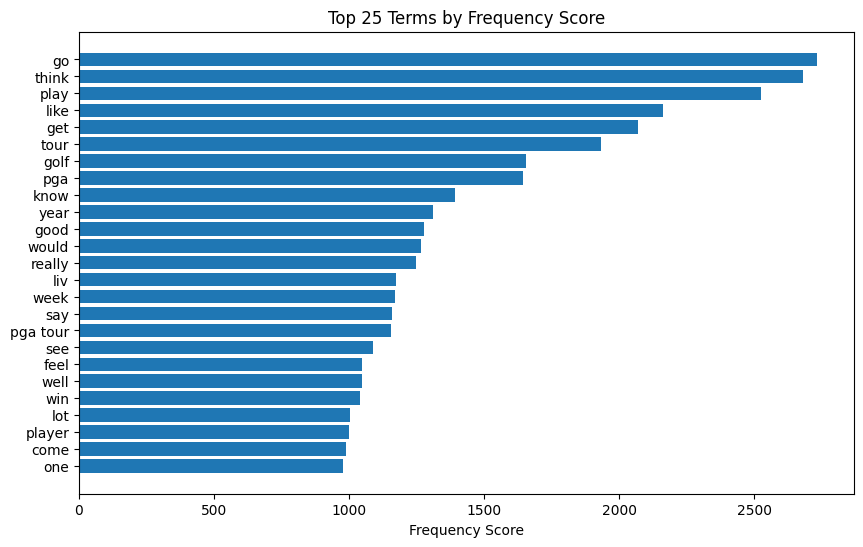

In [649]:
# Displays Most Relevant words
#pd.DataFrame.from_dict(diff_dicti, orient='index').reset_index()

def transform_to_dataframe(feature_names, score):
    # Create DataFrame with feature names and mean TF-IDF scores
    df = pd.DataFrame({'terms': feature_names, 'score': score})
    # Reset index
    df.reset_index(drop=True, inplace=True)
    return df

# Example usage:

df_count = transform_to_dataframe(feature_names, term_freq)
df_count = df_count.sort_values(by='score',ascending = False)
df_count = df_count.head(25)
#We are going to set the

# Plot the top N terms and their TF-IDF scores
plt.figure(figsize=(10, 6))
plt.barh(df_count['terms'], df_count['score'], align='center')
plt.yticks(df_count['terms'])
plt.xlabel('Frequency Score')
plt.title('Top {} Terms by Frequency Score'.format(25))
#plt.xlim(0,0.010)
plt.gca().invert_yaxis()  # Invert y-axis to display top terms at the top
plt.show()

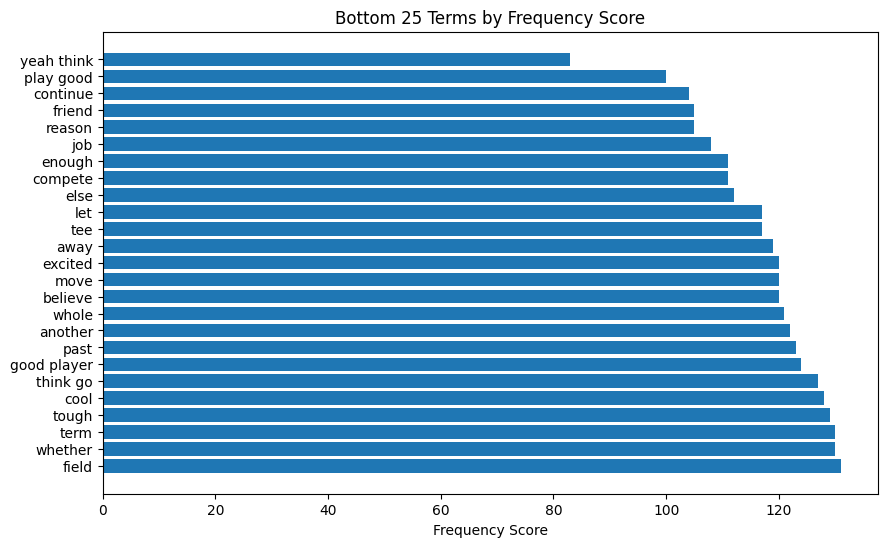

In [650]:
# Example usage:

df_count = transform_to_dataframe(feature_names, term_freq)
df_count = df_count.sort_values(by='score',ascending = True)
df_count = df_count.head(25)
#We are going to set the

# Plot the top N terms and their TF-IDF scores
plt.figure(figsize=(10, 6))
plt.barh(df_count['terms'], df_count['score'], align='center')
plt.yticks(df_count['terms'])
plt.xlabel('Frequency Score')
plt.title('Bottom {} Terms by Frequency Score'.format(25))
#plt.xlim(0,0.010)
plt.gca().invert_yaxis()  # Invert y-axis to display top terms at the top
plt.show()

### Create a tf-idf average score

In [651]:
# Convert count matrix to DataFrame
tfidf_mtx = pd.DataFrame(data=validation_tfidf, columns=feature_names)

tfidf_mtx.head()

,able,actually,ago,also,always,another,anything,around,ask,away,...,whether,whole,win,work,world,would,would say,yeah,yeah think,year
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.014718,0.000000,0.000000,0.000000,0.0,0.012844,0.0,0.000000
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.108877,0.0,0.000000,0.0,0.000000
2,0.0,0.0,0.0,0.113156,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.036393,0.0,...,0.0,0.0,0.000000,0.014769,0.094208,0.038710,0.0,0.000000,0.0,0.029678
4,0.0,0.0,0.0,0.000000,0.030149,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.068148,0.000000,0.000000,0.000000,0.0,0.009912,0.0,0.020010


In [652]:
feature_names = pipeline.named_steps['vect'].get_feature_names_out()
# Calculate the mean TF-IDF score for each term across all documents
mean_tfidf_scores = np.mean(tfidf_mtx, axis=0)
#Store in a dictionary
tfidf_dicti = {}
for i,n in zip(feature_names,mean_tfidf_scores):
  tfidf_dicti[i] = n

print(tfidf_dicti)

{'able': 0.004368801981780262, 'actually': 0.002522890411498324, 'ago': 0.0027094641232576783, 'also': 0.002895805942714029, 'always': 0.004066455075802952, 'another': 0.0020822188620100443, 'anything': 0.0034748987716470203, 'around': 0.003996194766585454, 'ask': 0.003345081580432987, 'away': 0.0019968459455910713, 'back': 0.007340665485652687, 'ball': 0.002682939079500251, 'believe': 0.001931703868793275, 'big': 0.004758855311624977, 'bit': 0.0051647993363794316, 'bring': 0.0028558414966789627, 'career': 0.0022767674112351413, 'championship': 0.004370692718515984, 'chance': 0.002966110901847345, 'change': 0.004790671079729536, 'close': 0.002451015143221094, 'come': 0.009037664587802764, 'compete': 0.0018523144031876925, 'continue': 0.0018791535146058566, 'cool': 0.0022771666484311974, 'could': 0.005952323684035648, 'couple': 0.003680083944889419, 'course': 0.007037254461341058, 'cup': 0.003478444596520429, 'day': 0.00555287763844558, 'decision': 0.003910223352821855, 'definitely': 0.

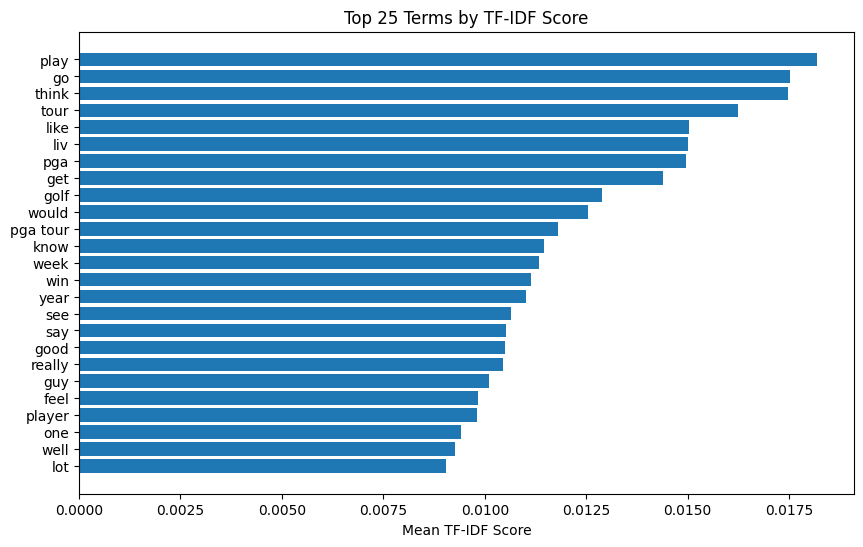

In [653]:
# Example usage:

df_tfidf = transform_to_dataframe(feature_names, mean_tfidf_scores)
df_tfidf = df_tfidf.sort_values(by='score',ascending = False)
df_tfidf = df_tfidf.head(25)
#We are going to set the

# Plot the top N terms and their TF-IDF scores
plt.figure(figsize=(10, 6))
plt.barh(df_tfidf['terms'], df_tfidf['score'], align='center')
plt.yticks(df_tfidf['terms'])
plt.xlabel('Mean TF-IDF Score')
plt.title('Top {} Terms by TF-IDF Score'.format(25))
#plt.xlim(0,0.010)
plt.gca().invert_yaxis()  # Invert y-axis to display top terms at the top
plt.show()

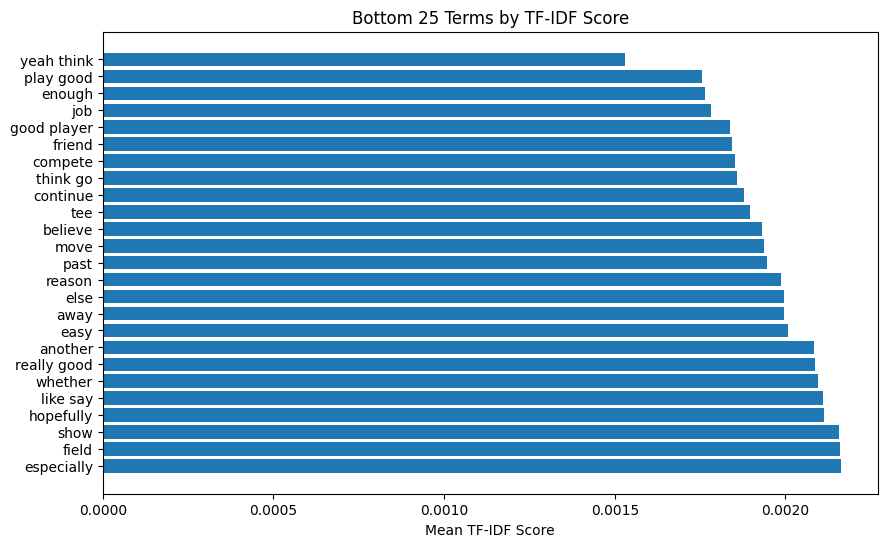

In [654]:
# Example usage:

df_tfidf = transform_to_dataframe(feature_names, mean_tfidf_scores)
df_tfidf = df_tfidf.sort_values(by='score',ascending = True)
df_tfidf = df_tfidf.head(25)
#We are going to set the

# Plot the top N terms and their TF-IDF scores
plt.figure(figsize=(10, 6))
plt.barh(df_tfidf['terms'], df_tfidf['score'], align='center')
plt.yticks(df_tfidf['terms'])
plt.xlabel('Mean TF-IDF Score')
plt.title('Bottom {} Terms by TF-IDF Score'.format(25))
#plt.xlim(0,0.010)
plt.gca().invert_yaxis()  # Invert y-axis to display top terms at the top
plt.show()

## Retrieving Topics using LDA

In [655]:
from sklearn.decomposition import LatentDirichletAllocation

# Specify the number of topics (adjust as needed)
num_topics = 10

# Initialize LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit the model to your TF-IDF matrix
lda.fit(tfidf_mtx)

LatentDirichletAllocation(random_state=42)

In [656]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")


# Print top words for each topic
print_top_words(lda, feature_names, n_top_words=10)

Topic #1: yeah think, let, play good, enough, job, good player, friend, compete, think go, continue
Topic #2: play, go, think, tour, liv, like, get, pga, golf, would
Topic #3: live, yeah think, let, play good, enough, job, good player, friend, compete, think go
Topic #4: yeah think, let, play good, enough, job, good player, friend, compete, think go, continue
Topic #5: yeah think, let, play good, enough, job, good player, friend, compete, think go, continue
Topic #6: yeah think, let, play good, enough, job, good player, friend, compete, think go, continue
Topic #7: yeah think, let, play good, enough, job, good player, friend, compete, think go, continue
Topic #8: little, yeah, yeah think, let, play good, enough, job, good player, friend, compete
Topic #9: pga, team, could, let, everybody, four, last, want, know, like
Topic #10: yeah think, let, play good, enough, job, good player, friend, compete, think go, continue


### SENTIMENT ANALYSIS

VADER ( Valence Aware Dictionary for Sentiment Reasoning) is a module used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is applied directly to unlabeled text data and is specifically designed for sentiments expressed in social media.

VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in each of the following categories:

negative
neutral
positive
compound (the sum of positive, negative & neutral scores which is then normalized between -1(strongly negative) and +1 (strongly positive).
For example, the following text would return these output scores:
‘This was the best, most awesome movie EVER MADE!!!’
OUTPUT-{‘neg’: 0.0, ‘neu’: 0.425, ‘pos’: 0.575, ‘compound’: 0.8877})

The compound scores range between -1 to 1, with -1 being strongly negative and +1 being strongly positive. 
We'll use compund to determine both the sign and the strength of the sentiment.

In [657]:
# Initialize the SentimentIntensityAnalyzer.
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

# Apply lambda function to get compound scores.
function = lambda title: vader.polarity_scores(title)['compound']
df_nlp['sentiment'] = df_nlp['prepro_interviews'].apply(function)

df_nlp['answer_prep_length'] = [len(i.split()) for i in df_nlp['prepro_interviews']]

test = df_nlp[['prepro_interviews','answer_prep_length','sentiment','PGA','LIV']]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mikelgallo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                    answer_prep_length  sentiment
answer_prep_length            1.000000   0.462921
sentiment                     0.462921   1.000000


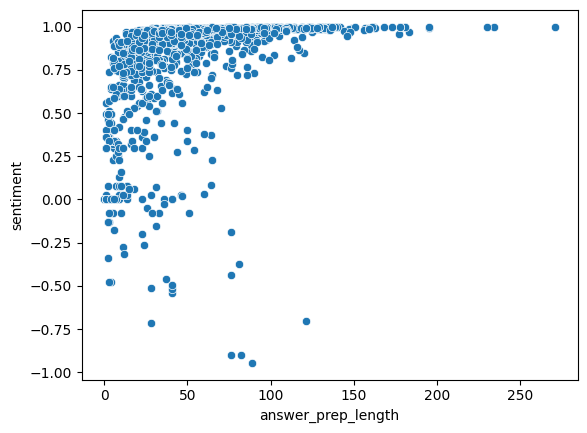

In [658]:
import seaborn as sns
import matplotlib.pyplot as plt

print(test[['answer_prep_length','sentiment']].corr())
# Assuming 'test' is your DataFrame
sns.scatterplot(data=test, x='answer_prep_length', y='sentiment')
plt.show()


                    answer_prep_length  sentiment_scaled
answer_prep_length            1.000000         -0.358883
sentiment_scaled             -0.358883          1.000000


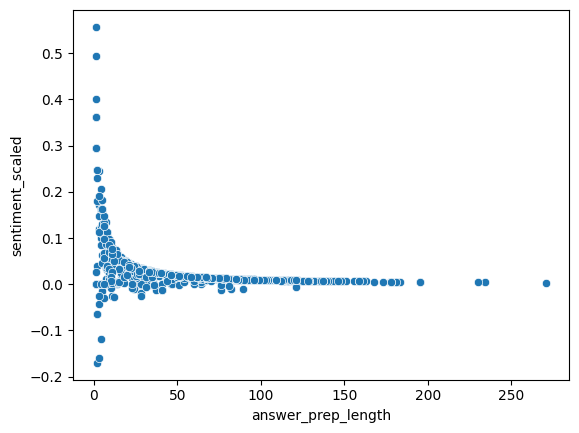

In [659]:
##Scaling scores
df_nlp['sentiment_scaled'] = df_nlp['sentiment'] / df_nlp['answer_prep_length']

print(df_nlp[['answer_prep_length','sentiment_scaled']].corr())
# Assuming 'test' is your DataFrame
sns.scatterplot(data=df_nlp, x='answer_prep_length', y='sentiment_scaled')
plt.show()

In [660]:
#Adding Sentiment Label
def getAnalysis(score):
 if score < 0:
    return 'Negative'
 elif score == 0:
    return 'Neutral'
 else:
    return 'Positive'

df_nlp['sentiment_label'] = df_nlp['sentiment_scaled'].apply(getAnalysis)


#Labeling answer type
df_nlp['anwer_topic'] = ['pga' if i ==1 and n== 0 else 'liv' if i==0 and n==1 else 'both' if i==1 and n==1 else 'other' for i,n in zip(df_nlp['PGA'], df_nlp['LIV']) ]

#Scaling score to the length of the review
df_nlp.head(5)

,player,LIV_Player,year_month,year,answer_length,PGA,LIV,question,reply_sentence,prepro_interviews,prepro_questions,LIV_CHANGE,two_question_text,sentiment,answer_prep_length,sentiment_scaled,sentiment_label,anwer_topic
0,rory mcilroy,0,2024-02,2024,111,1,0,third start this season had a chance to play p...,yeah so third start on the pga tour i had two ...,yeah third start pga tour two event middle eas...,third start season chance play pebble genesis ...,0,yeah third start pga tour two event middle eas...,0.9901,59,0.016781,Positive,pga
1,rory mcilroy,0,2024-02,2024,7,0,1,he started by saying there is a good chance yo...,somewhere in the middle maybe who knows,somewhere middle maybe know,start say good chance would go liv percentage,0,somewhere middle maybe know start say good cha...,0.0000,4,0.000000,Neutral,liv
2,rory mcilroy,0,2024-01,2024,6,0,1,but do you think that it's also reflective of ...,just buy sky sports i guess,buy sky sport guess,think also reflective attitude debate fact say...,0,buy sky sport guess think also reflective atti...,0.0000,4,0.000000,Neutral,liv
3,rory mcilroy,0,2024-01,2024,129,1,0,i can't help asking about asia this year proba...,absolutely i spoke to dr munjal on the course ...,absolutely speak dr munjal course today know g...,help ask asia year probably dp world tour one ...,0,absolutely speak dr munjal course today know g...,0.7845,53,0.014802,Positive,pga
4,rory mcilroy,0,2024-01,2024,146,0,1,you have that wonderful privilege of going bac...,yeah it was obviously the first win of my prof...,yeah obviously first win professional career f...,wonderful privilege go back golf course win qu...,0,yeah obviously first win professional career f...,0.9891,64,0.015455,Positive,liv


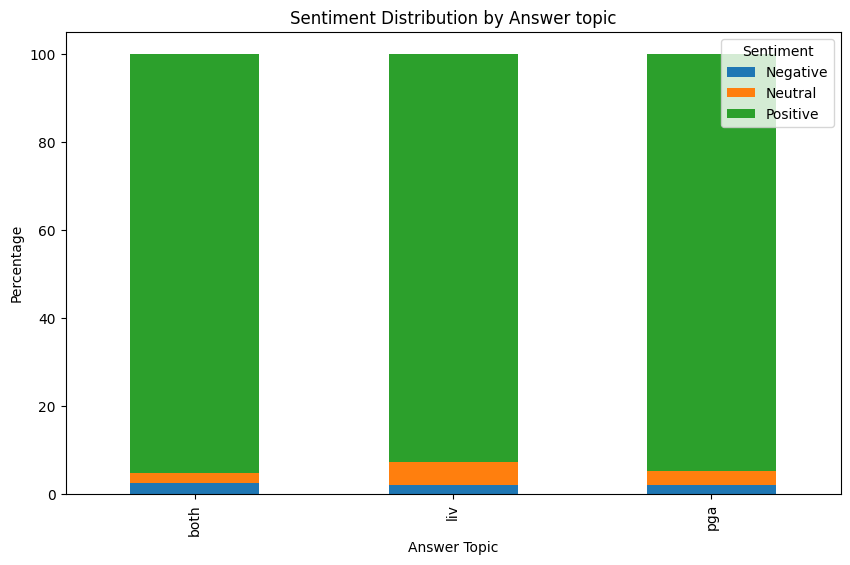

In [661]:
# Group data by 'answer_label' and 'sentiment_label', and calculate counts
grouped = df_nlp.groupby(['anwer_topic', 'sentiment_label']).size().unstack(fill_value=0)

# Convert counts to percentages
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
ax = grouped_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set labels and title
ax.set_xlabel('Answer Topic')
ax.set_ylabel('Percentage')
ax.set_title('Sentiment Distribution by Answer topic')

# Show legend
ax.legend(title='Sentiment')

# Show plot
plt.show()

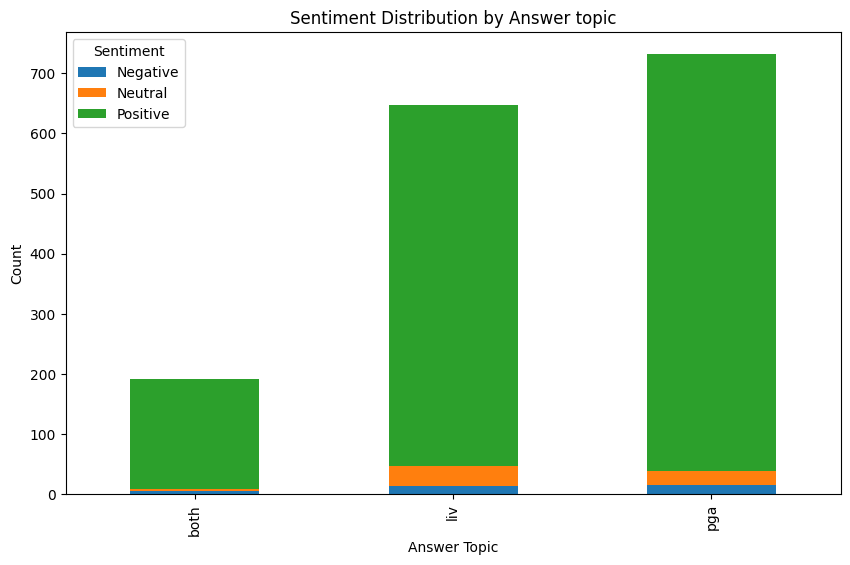

In [662]:
# Group data by 'answer_label' and 'sentiment_label', and calculate counts
grouped = df_nlp.groupby(['anwer_topic', 'sentiment_label']).size().unstack(fill_value=0)

# Plot stacked bar chart
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set labels and title
ax.set_xlabel('Answer Topic')
ax.set_ylabel('Count')
ax.set_title('Sentiment Distribution by Answer topic')

# Show legend
ax.legend(title='Sentiment')

# Show plot
plt.show()

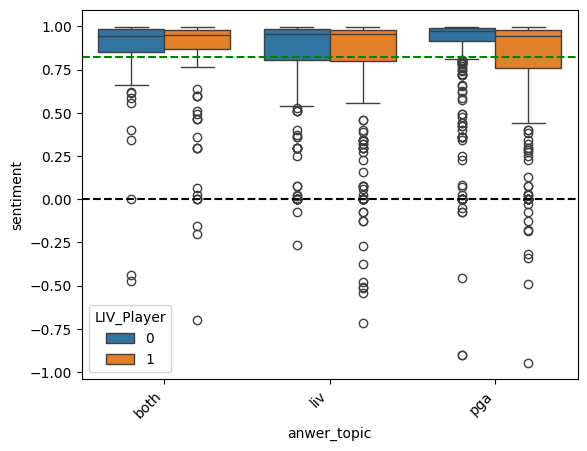

In [663]:
df_pre_ordered = df_nlp.sort_values(by='anwer_topic',ascending=True)

sns.boxplot(data=df_pre_ordered, x='anwer_topic', y='sentiment',hue='LIV_Player', fill=True)
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_pre_ordered['sentiment'].mean()
plt.axhline(y=mean_reply_length, color='green', linestyle='--', label=f'Mean sentiment ({mean_reply_length:.2f})')
plt.axhline(y=0, color='black', linestyle='--', label=f'Neutral')
# Show the plot
plt.show()

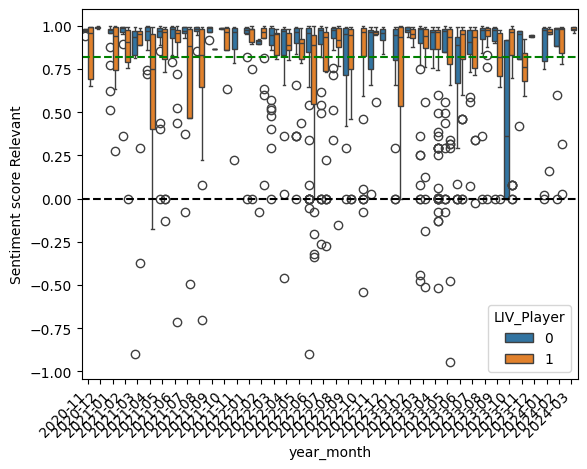

In [664]:
## Overall sentiment
df_pre_ordered = df_nlp.sort_values(by='year_month',ascending=True)

sns.boxplot(data=df_pre_ordered, x='year_month', y='sentiment',hue='LIV_Player', fill=True)
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_pre_ordered['sentiment'].mean()
plt.axhline(y=mean_reply_length, color='green', linestyle='--', label=f'Mean sentiment ({mean_reply_length:.2f})')
plt.axhline(y=0, color='black', linestyle='--', label=f'Neutral')
plt.ylabel('Sentiment score Relevant')
# Show the plot
plt.show()

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_9495/390758587.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:green'` for the same effect.

  sns.boxplot(data=df_pre_ordered, x='year_month', y='sentiment',hue='LIV_Player', fill=True,color='green')


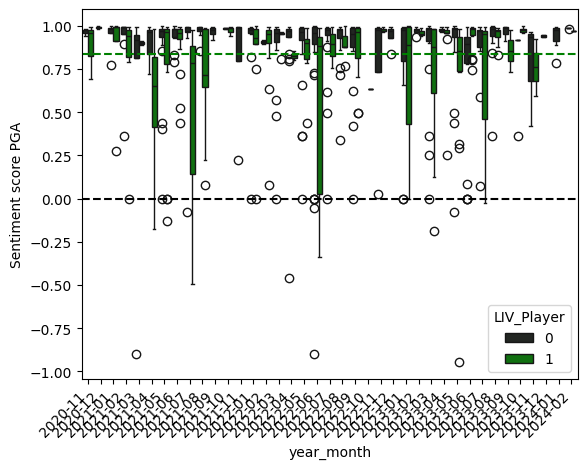

In [665]:
## Overall sentiment
df_pre_ordered = df_nlp[df_nlp['anwer_topic']=='pga'].sort_values(by='year_month',ascending=True)

sns.boxplot(data=df_pre_ordered, x='year_month', y='sentiment',hue='LIV_Player', fill=True,color='green')
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_pre_ordered['sentiment'].mean()
plt.axhline(y=mean_reply_length, color='green', linestyle='--', label=f'Mean sentiment ({mean_reply_length:.2f})')
plt.axhline(y=0, color='black', linestyle='--', label=f'Neutral')
plt.ylabel('Sentiment score PGA')
# Show the plot
plt.show()

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_9495/3998924632.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  sns.boxplot(data=df_pre_ordered, x='year_month', y='sentiment', hue='LIV_Player',fill=True,color='red')


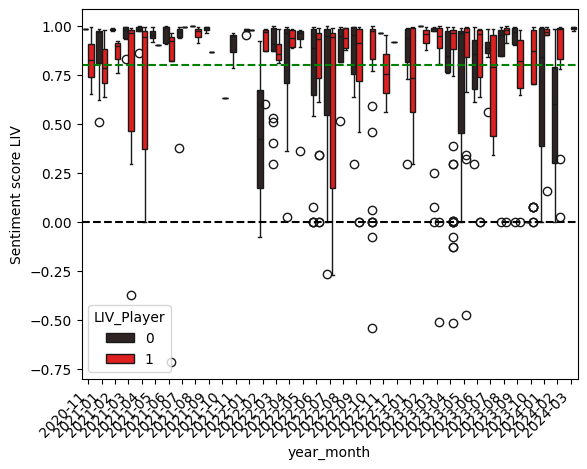

In [666]:
## Overall sentiment
df_pre_ordered = df_nlp[df_nlp['anwer_topic']=='liv'].sort_values(by='year_month',ascending=True)

sns.boxplot(data=df_pre_ordered, x='year_month', y='sentiment', hue='LIV_Player',fill=True,color='red')
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_pre_ordered['sentiment'].mean()
plt.axhline(y=mean_reply_length, color='green', linestyle='--', label=f'Mean sentiment ({mean_reply_length:.2f})')
plt.axhline(y=0, color='black', linestyle='--', label=f'Neutral')
plt.ylabel('Sentiment score LIV')
# Show the plot
plt.show()

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_9495/579126731.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.boxplot(data=df_pre_ordered, x='year_month', y='sentiment',hue = 'LIV_Player', fill=True,color='grey')


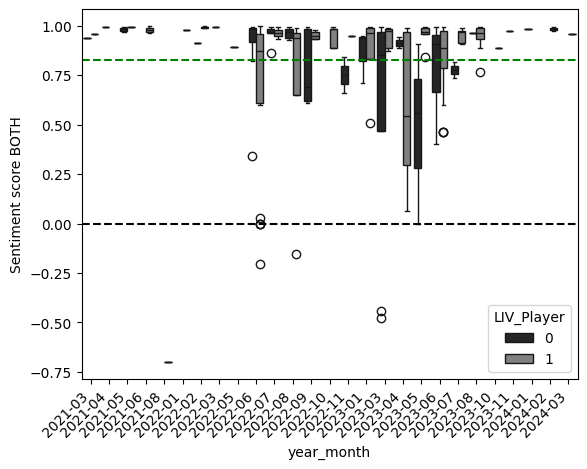

In [667]:
## Overall sentiment
df_pre_ordered = df_nlp[df_nlp['anwer_topic']=='both'].sort_values(by='year_month',ascending=True)

sns.boxplot(data=df_pre_ordered, x='year_month', y='sentiment',hue = 'LIV_Player', fill=True,color='grey')
#plt.xlim(0, None)
plt.xticks(rotation=45, ha='right')
# Add a horizontal line at the mean of 'reply_length'
mean_reply_length = df_pre_ordered['sentiment'].mean()
plt.axhline(y=mean_reply_length, color='green', linestyle='--', label=f'Mean sentiment ({mean_reply_length:.2f})')
plt.axhline(y=0, color='black', linestyle='--', label=f'Neutral')
plt.ylabel('Sentiment score BOTH')
# Show the plot
plt.show()

## Sentiment score per month & player

In [668]:
df_nlp.head()

,player,LIV_Player,year_month,year,answer_length,PGA,LIV,question,reply_sentence,prepro_interviews,prepro_questions,LIV_CHANGE,two_question_text,sentiment,answer_prep_length,sentiment_scaled,sentiment_label,anwer_topic
0,rory mcilroy,0,2024-02,2024,111,1,0,third start this season had a chance to play p...,yeah so third start on the pga tour i had two ...,yeah third start pga tour two event middle eas...,third start season chance play pebble genesis ...,0,yeah third start pga tour two event middle eas...,0.9901,59,0.016781,Positive,pga
1,rory mcilroy,0,2024-02,2024,7,0,1,he started by saying there is a good chance yo...,somewhere in the middle maybe who knows,somewhere middle maybe know,start say good chance would go liv percentage,0,somewhere middle maybe know start say good cha...,0.0000,4,0.000000,Neutral,liv
2,rory mcilroy,0,2024-01,2024,6,0,1,but do you think that it's also reflective of ...,just buy sky sports i guess,buy sky sport guess,think also reflective attitude debate fact say...,0,buy sky sport guess think also reflective atti...,0.0000,4,0.000000,Neutral,liv
3,rory mcilroy,0,2024-01,2024,129,1,0,i can't help asking about asia this year proba...,absolutely i spoke to dr munjal on the course ...,absolutely speak dr munjal course today know g...,help ask asia year probably dp world tour one ...,0,absolutely speak dr munjal course today know g...,0.7845,53,0.014802,Positive,pga
4,rory mcilroy,0,2024-01,2024,146,0,1,you have that wonderful privilege of going bac...,yeah it was obviously the first win of my prof...,yeah obviously first win professional career f...,wonderful privilege go back golf course win qu...,0,yeah obviously first win professional career f...,0.9891,64,0.015455,Positive,liv


In [669]:

df_sent_month = df_nlp.groupby(['player', 'year_month','anwer_topic']).agg({'LIV_Player': 'max','LIV_CHANGE': 'max', 'sentiment': 'mean'}).reset_index()
#Concatenate separately replies and questions by month 
df_sent_month

,player,year_month,anwer_topic,LIV_Player,LIV_CHANGE,sentiment
0,brooks koepka,2020-11,liv,1,0,0.651700
1,brooks koepka,2020-11,pga,1,0,0.958400
2,brooks koepka,2021-02,liv,1,0,0.839250
3,brooks koepka,2021-02,pga,1,0,0.790600
4,brooks koepka,2021-04,pga,1,0,0.670867
...,...,...,...,...,...,...
471,sergio garcia,2023-06,both,1,0,0.906100
472,sergio garcia,2023-06,liv,1,0,0.517933
473,sergio garcia,2023-08,both,1,0,0.921700
474,sergio garcia,2023-08,liv,1,0,0.970775


### Defining player cohorts

In [670]:
print(df_nlp[df_nlp['LIV_Player']==1]['player'].unique())
print(df_nlp[df_nlp['LIV_Player']==0]['player'].unique())

['jon rahm' 'sergio garcia' 'phil mickelson' 'brooks koepka'
 'dustin johnson' 'cameron smith']
['rory mcilroy' 'jordan spieth' 'justin thomas' 'scottie scheffler'
 'collin morikawa']


In [671]:
cohort1 = ['jon rahm' , 'rory mcilroy', 'sergio garcia' ]
cohort2 = ['jordan spieth', 'phil mickelson', 'justin thomas' ]
cohort3 = ['brooks koepka', 'scottie scheffler', 'dustin johnson']
cohort4 = ['cameron smith',  'collin morikawa']

## PGA Sentiment Analysis

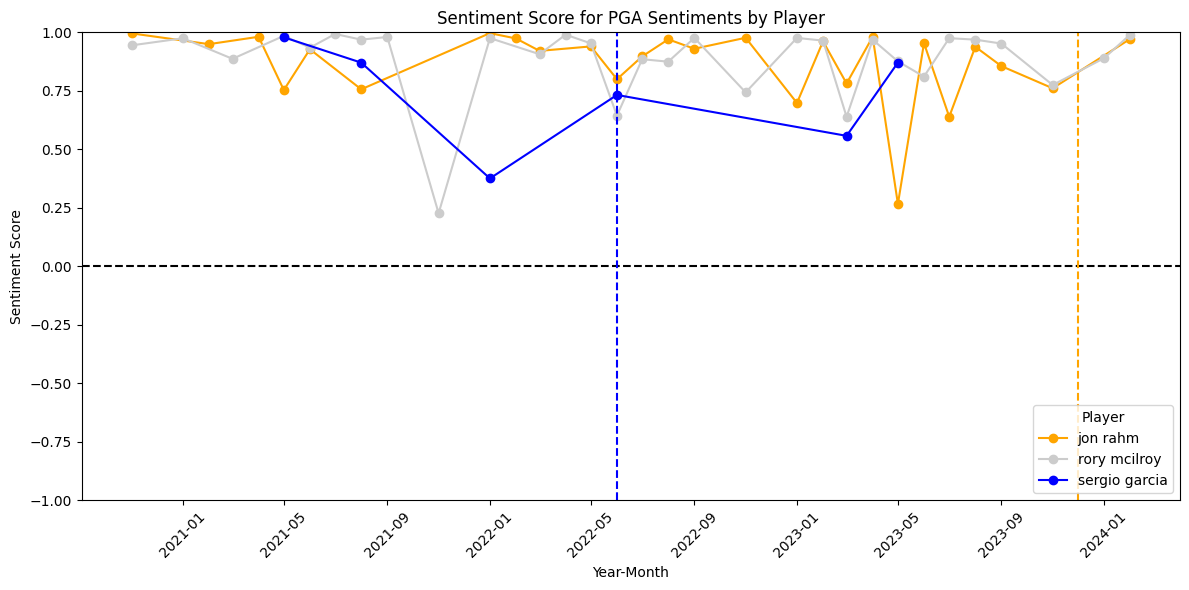

In [672]:
#Defining Cohort 1:
group_ = cohort1

df_month_pga = df_sent_month[(df_sent_month['anwer_topic']=='pga')&(df_sent_month['player'].isin(group_))][['player','year_month','sentiment']]

# Convert 'year_month' to datetime type
df_month_pga['year_month'] = pd.to_datetime(df_month_pga['year_month'])

# Sort DataFrame by 'year_month'
df_month_pga = df_month_pga.sort_values(by='year_month')

# Define colors for players
player_colors = {'rory mcilroy': '#CCCCCC', 'sergio garcia': 'blue', 'jon rahm': 'orange'}

# Plot the lines for each player
plt.figure(figsize=(12, 6))
for player, data in df_month_pga.groupby('player'):
    color = player_colors.get(player, 'lightgray')  # Default color is lightgray if player not in player_colors
    plt.plot(data['year_month'], data['sentiment'], marker='o', label=player, linestyle='-', color=color)

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score for PGA Sentiments by Player')

# Show legend
plt.legend(title='Player', loc='lower right')

#lines
plt.axhline(y=0, color='black', linestyle='--', label=f'Neutral')

#Adding Date of LIV Change

#'sergio garcia'
plt.axvline(x=pd.to_datetime('2022-06'), color='blue', linestyle='--', label=f'LIV')
plt.axvline(x=pd.to_datetime('2023-12'), color='orange', linestyle='--', label=f'LIV')

# Show plot
plt.grid(False)
plt.ylim(-1,1)
#plt.ylim(-0.05,0.2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

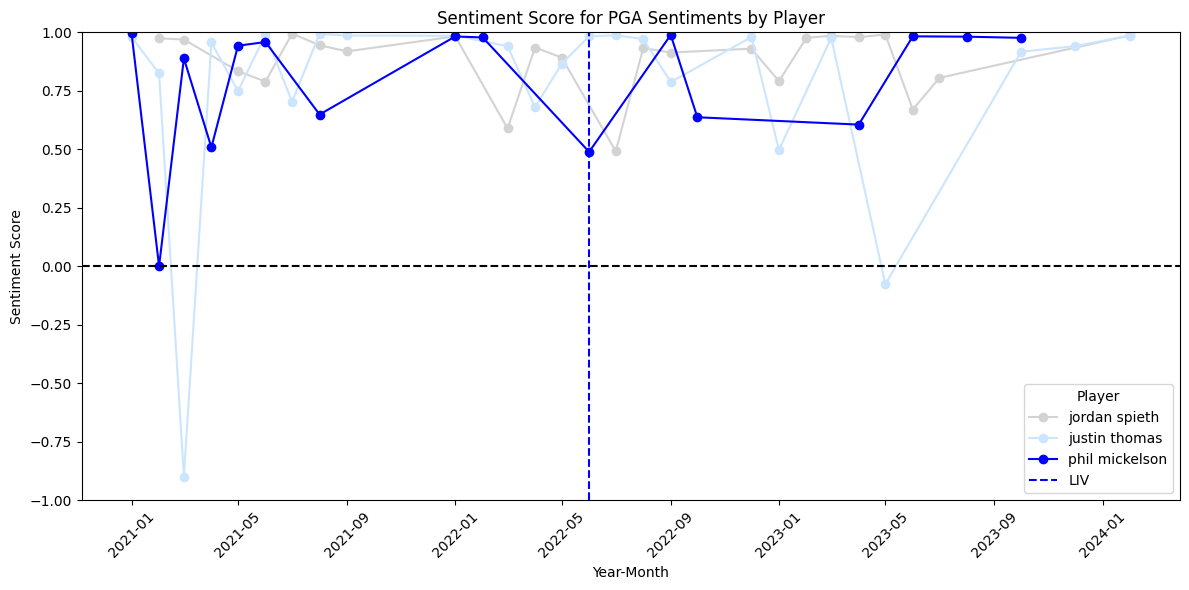

In [673]:
#Defining Cohort 2:
group_ = cohort2

df_month_pga = df_sent_month[(df_sent_month['anwer_topic']=='pga')&(df_sent_month['player'].isin(group_))][['player','year_month','sentiment']]

# Convert 'year_month' to datetime type
df_month_pga['year_month'] = pd.to_datetime(df_month_pga['year_month'])

# Sort DataFrame by 'year_month'
df_month_pga = df_month_pga.sort_values(by='year_month')

# Define colors for players
player_colors = {'jordan spieth': 'lightgray', 'justin thomas': '#CCE5FF', 'phil mickelson': 'blue'}

# Plot the lines for each player
plt.figure(figsize=(12, 6))
for player, data in df_month_pga.groupby('player'):
    color = player_colors.get(player, 'lightgray')  # Default color is lightgray if player not in player_colors
    plt.plot(data['year_month'], data['sentiment'], marker='o', label=player, linestyle='-', color=color)

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score for PGA Sentiments by Player')

#'sergio garcia'
plt.axvline(x=pd.to_datetime('2022-06'), color='blue', linestyle='--', label=f'LIV')

# Show legend
plt.legend(title='Player', loc='lower right')

#lines
plt.axhline(y=0, color='black', linestyle='--', label=f'Neutral')

# Show plot
plt.grid(False)
plt.ylim(-1,1)
#plt.ylim(-0.05,0.2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

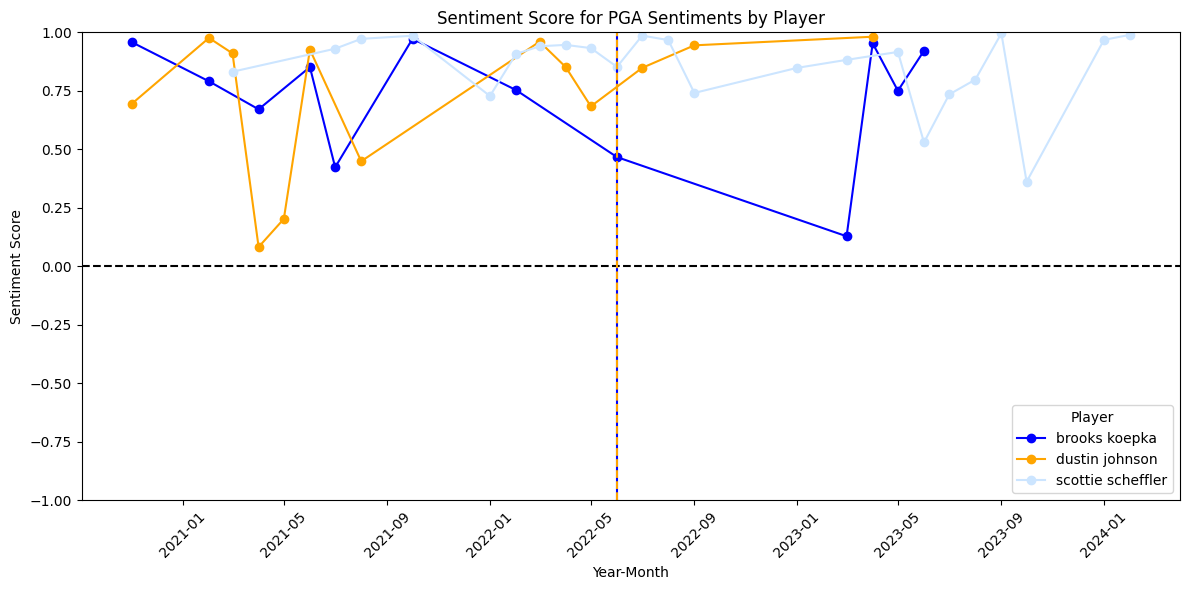

In [674]:
#Defining Cohort 3:
group_ = cohort3

df_month_pga = df_sent_month[(df_sent_month['anwer_topic']=='pga')&(df_sent_month['player'].isin(group_))][['player','year_month','sentiment']]

# Convert 'year_month' to datetime type
df_month_pga['year_month'] = pd.to_datetime(df_month_pga['year_month'])

# Sort DataFrame by 'year_month'
df_month_pga = df_month_pga.sort_values(by='year_month')

# Define colors for players
player_colors = {'scottie scheffler': '#CCE5FF', 'dustin johnson': 'orange', 'brooks koepka': 'blue'}

# Plot the lines for each player
plt.figure(figsize=(12, 6))
for player, data in df_month_pga.groupby('player'):
    color = player_colors.get(player, 'lightgray')  # Default color is lightgray if player not in player_colors
    plt.plot(data['year_month'], data['sentiment'], marker='o', label=player, linestyle='-', color=color)

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score for PGA Sentiments by Player')

# Show legend
plt.legend(title='Player', loc='lower right')

#lines
plt.axhline(y=0, color='black', linestyle='--', label=f'Neutral')

plt.axvline(x=pd.to_datetime('2022-06'), color='blue', linestyle='-', label=f'LIV')
plt.axvline(x=pd.to_datetime('2022-06'), color='orange', linestyle='--', label=f'LIV')

# Show plot
plt.grid(False)
#plt.ylim(-0.05,0.2)
plt.ylim(-1,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

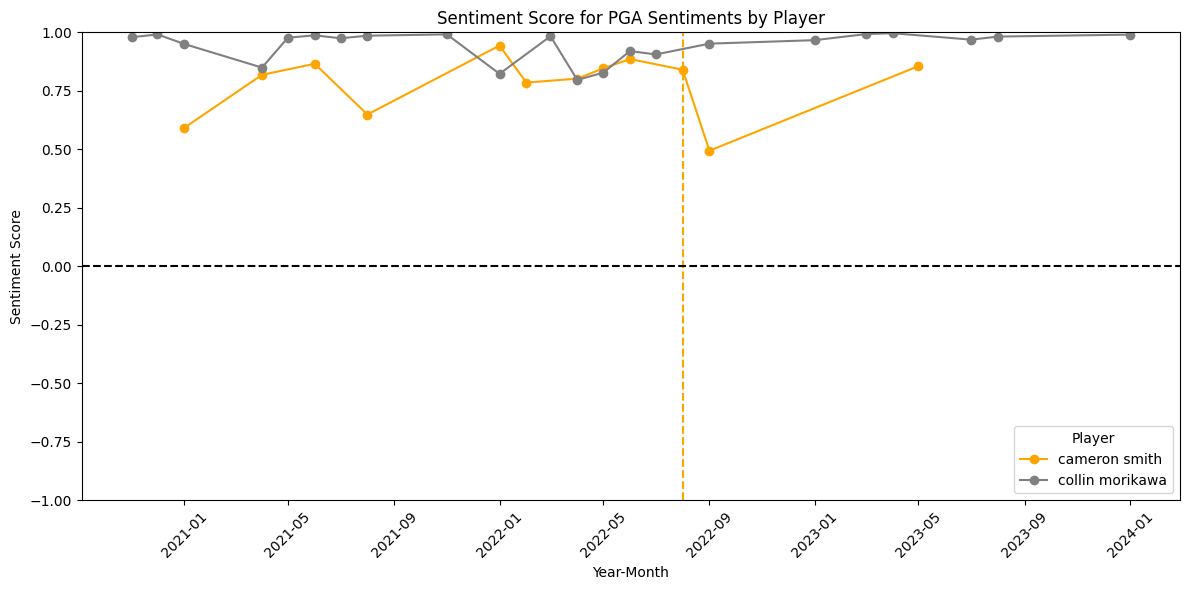

In [675]:
#Defining Cohort 4:
group_ = cohort4

df_month_pga = df_sent_month[(df_sent_month['anwer_topic']=='pga')&(df_sent_month['player'].isin(group_))][['player','year_month','sentiment']]

# Convert 'year_month' to datetime type
df_month_pga['year_month'] = pd.to_datetime(df_month_pga['year_month'])

# Sort DataFrame by 'year_month'
df_month_pga = df_month_pga.sort_values(by='year_month')

# Define colors for players
player_colors = {'collin morikawa': 'gray', 'cameron smith': 'orange'}

# Plot the lines for each player
plt.figure(figsize=(12, 6))
for player, data in df_month_pga.groupby('player'):
    color = player_colors.get(player, 'lightgray')  # Default color is lightgray if player not in player_colors
    plt.plot(data['year_month'], data['sentiment'], marker='o', label=player, linestyle='-', color=color)

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score for PGA Sentiments by Player')

# Show legend
plt.legend(title='Player', loc='lower right')

plt.axvline(x=pd.to_datetime('2022-08'), color='orange', linestyle='--', label=f'LIV')

#lines
plt.axhline(y=0, color='black', linestyle='--', label=f'Neutral')

# Show plot
plt.grid(False)
#plt.ylim(-0.3,0.3)
plt.ylim(-1,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## LIV sentiment analysis

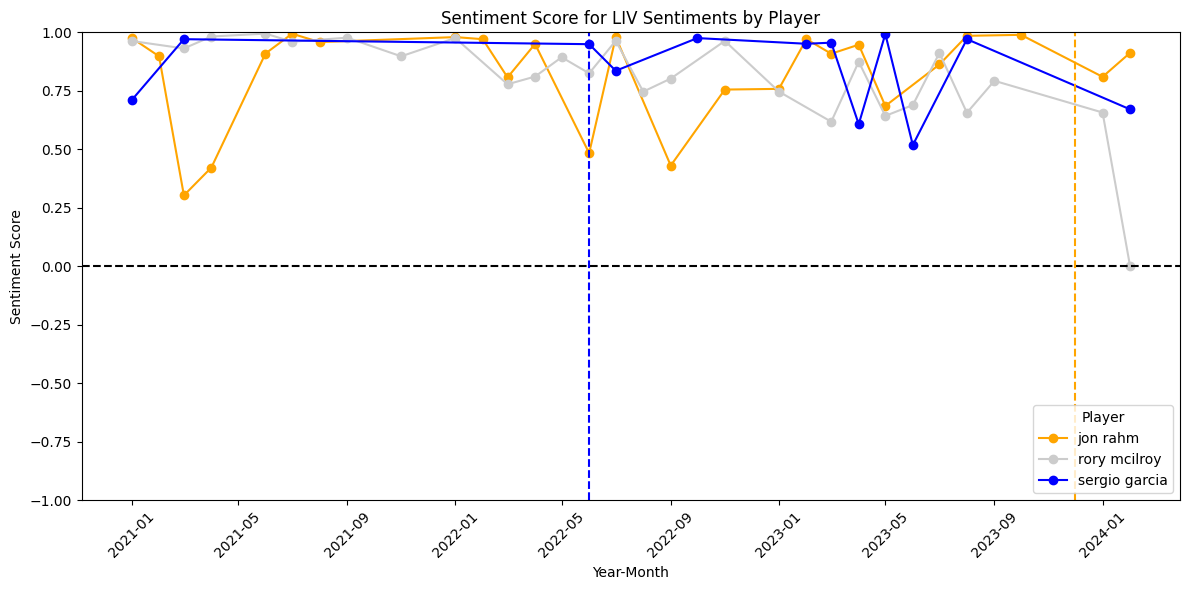

In [676]:
#Defining Cohort 1:
group_ = cohort1

df_month_pga = df_sent_month[(df_sent_month['anwer_topic']=='liv')&(df_sent_month['player'].isin(group_))][['player','year_month','sentiment']]

# Convert 'year_month' to datetime type
df_month_pga['year_month'] = pd.to_datetime(df_month_pga['year_month'])

# Sort DataFrame by 'year_month'
df_month_pga = df_month_pga.sort_values(by='year_month')

# Define colors for players
player_colors = {'rory mcilroy': '#CCCCCC', 'sergio garcia': 'blue', 'jon rahm': 'orange'}

# Plot the lines for each player
plt.figure(figsize=(12, 6))
for player, data in df_month_pga.groupby('player'):
    color = player_colors.get(player, 'lightgray')  # Default color is lightgray if player not in player_colors
    plt.plot(data['year_month'], data['sentiment'], marker='o', label=player, linestyle='-', color=color)

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score for LIV Sentiments by Player')

# Show legend
plt.legend(title='Player', loc='lower right')

#lines
plt.axhline(y=0, color='black', linestyle='--', label=f'Neutral')

#Adding Date of LIV Change

#'sergio garcia'
plt.axvline(x=pd.to_datetime('2022-06'), color='blue', linestyle='--', label=f'LIV')
plt.axvline(x=pd.to_datetime('2023-12'), color='orange', linestyle='--', label=f'LIV')

# Show plot
plt.grid(False)
plt.ylim(-1,1)
#plt.ylim(-0.05,0.2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

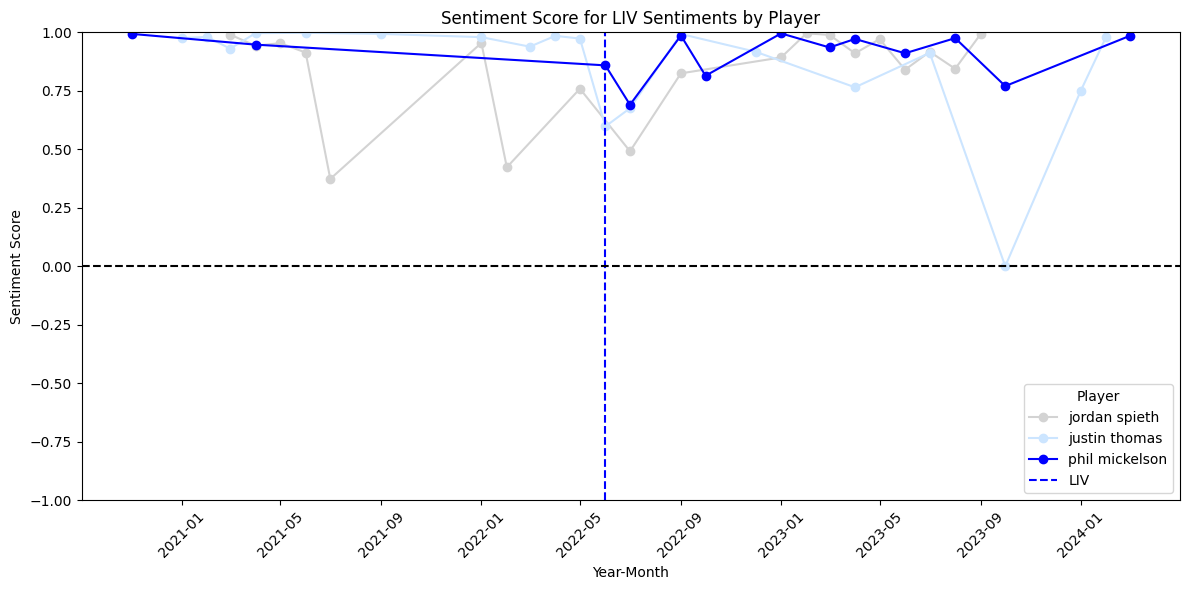

In [677]:
#Defining Cohort 2:
group_ = cohort2

df_month_pga = df_sent_month[(df_sent_month['anwer_topic']=='liv')&(df_sent_month['player'].isin(group_))][['player','year_month','sentiment']]

# Convert 'year_month' to datetime type
df_month_pga['year_month'] = pd.to_datetime(df_month_pga['year_month'])

# Sort DataFrame by 'year_month'
df_month_pga = df_month_pga.sort_values(by='year_month')

# Define colors for players
player_colors = {'jordan spieth': 'lightgray', 'justin thomas': '#CCE5FF', 'phil mickelson': 'blue'}

# Plot the lines for each player
plt.figure(figsize=(12, 6))
for player, data in df_month_pga.groupby('player'):
    color = player_colors.get(player, 'lightgray')  # Default color is lightgray if player not in player_colors
    plt.plot(data['year_month'], data['sentiment'], marker='o', label=player, linestyle='-', color=color)

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score for LIV Sentiments by Player')

#'sergio garcia'
plt.axvline(x=pd.to_datetime('2022-06'), color='blue', linestyle='--', label=f'LIV')

# Show legend
plt.legend(title='Player', loc='lower right')

#lines
plt.axhline(y=0, color='black', linestyle='--', label=f'Neutral')

# Show plot
plt.grid(False)
plt.ylim(-1,1)
#plt.ylim(-0.05,0.2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

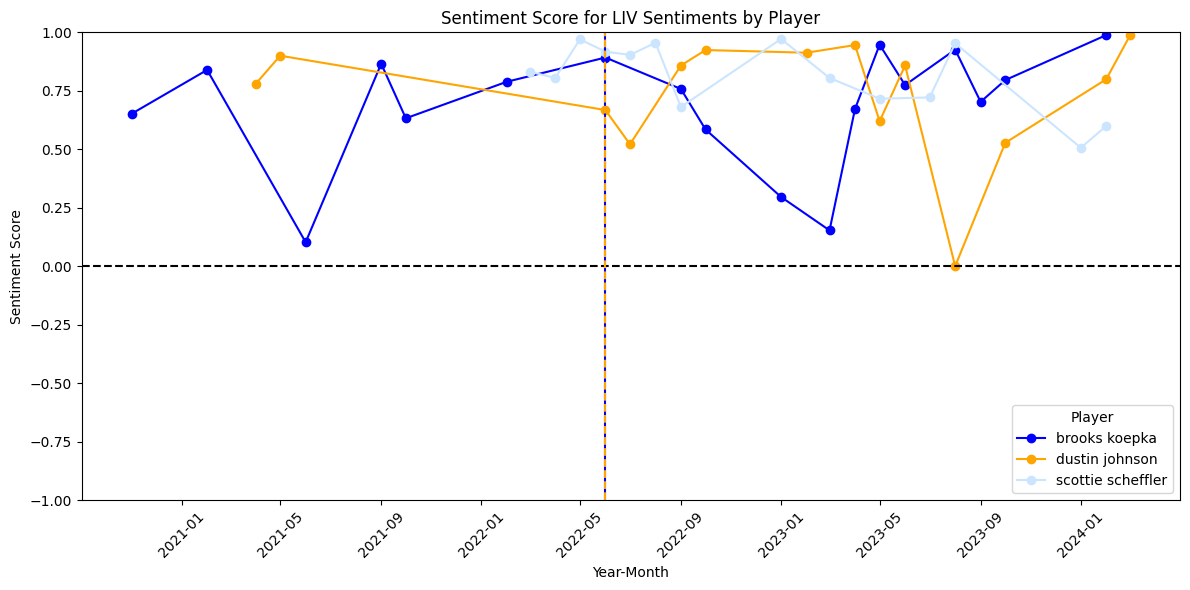

In [678]:
#Defining Cohort 3:
group_ = cohort3

df_month_pga = df_sent_month[(df_sent_month['anwer_topic']=='liv')&(df_sent_month['player'].isin(group_))][['player','year_month','sentiment']]

# Convert 'year_month' to datetime type
df_month_pga['year_month'] = pd.to_datetime(df_month_pga['year_month'])

# Sort DataFrame by 'year_month'
df_month_pga = df_month_pga.sort_values(by='year_month')

# Define colors for players
player_colors = {'scottie scheffler': '#CCE5FF', 'dustin johnson': 'orange', 'brooks koepka': 'blue'}

# Plot the lines for each player
plt.figure(figsize=(12, 6))
for player, data in df_month_pga.groupby('player'):
    color = player_colors.get(player, 'lightgray')  # Default color is lightgray if player not in player_colors
    plt.plot(data['year_month'], data['sentiment'], marker='o', label=player, linestyle='-', color=color)

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score for LIV Sentiments by Player')

# Show legend
plt.legend(title='Player', loc='lower right')

#lines
plt.axhline(y=0, color='black', linestyle='--', label=f'Neutral')

plt.axvline(x=pd.to_datetime('2022-06'), color='blue', linestyle='-', label=f'LIV')
plt.axvline(x=pd.to_datetime('2022-06'), color='orange', linestyle='--', label=f'LIV')

# Show plot
plt.grid(False)
#plt.ylim(-0.05,0.2)
plt.ylim(-1,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

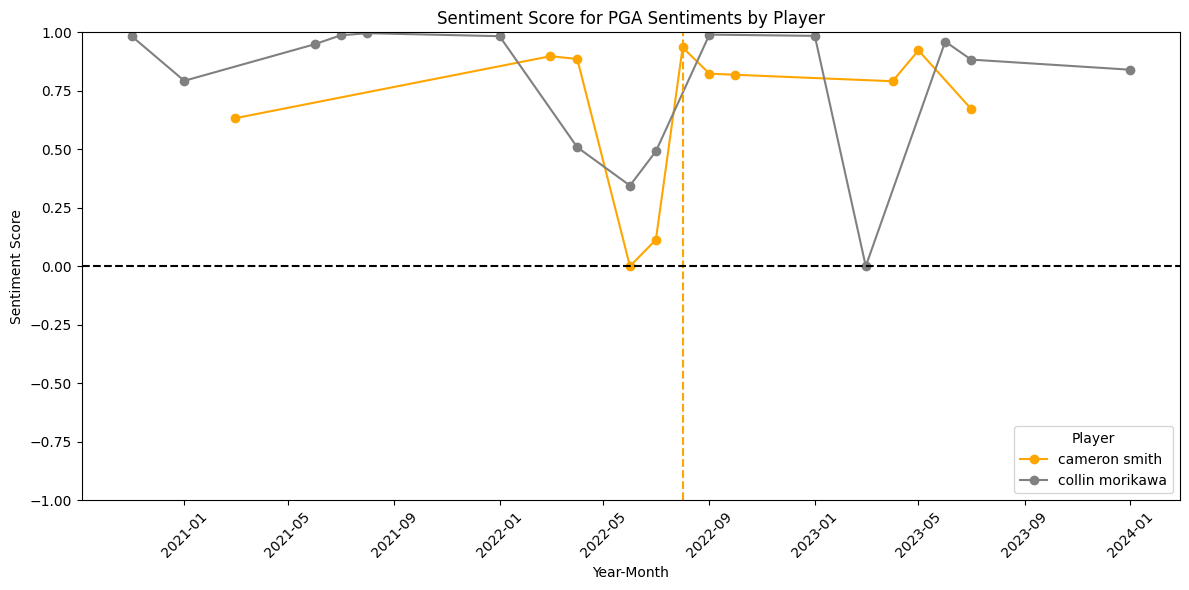

In [679]:
#Defining Cohort 4:
group_ = cohort4

df_month_pga = df_sent_month[(df_sent_month['anwer_topic']=='liv')&(df_sent_month['player'].isin(group_))][['player','year_month','sentiment']]

# Convert 'year_month' to datetime type
df_month_pga['year_month'] = pd.to_datetime(df_month_pga['year_month'])

# Sort DataFrame by 'year_month'
df_month_pga = df_month_pga.sort_values(by='year_month')

# Define colors for players
player_colors = {'collin morikawa': 'gray', 'cameron smith': 'orange'}

# Plot the lines for each player
plt.figure(figsize=(12, 6))
for player, data in df_month_pga.groupby('player'):
    color = player_colors.get(player, 'lightgray')  # Default color is lightgray if player not in player_colors
    plt.plot(data['year_month'], data['sentiment'], marker='o', label=player, linestyle='-', color=color)

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score for PGA Sentiments by Player')

# Show legend
plt.legend(title='Player', loc='lower right')

plt.axvline(x=pd.to_datetime('2022-08'), color='orange', linestyle='--', label=f'LIV')

#lines
plt.axhline(y=0, color='black', linestyle='--', label=f'Neutral')

# Show plot
plt.grid(False)
#plt.ylim(-0.3,0.3)
plt.ylim(-1,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Studying Percentage change in PGA sentiment of LIV and PGA players

In [680]:
df_pga = df_sent_month[df_sent_month['anwer_topic']=='pga'][['player','year_month','sentiment']]
df_pga.head()

,player,year_month,sentiment
1,brooks koepka,2020-11,0.958400
3,brooks koepka,2021-02,0.790600
4,brooks koepka,2021-04,0.670867
7,brooks koepka,2021-06,0.851413
8,brooks koepka,2021-07,0.423000


In [681]:
# Convert 'year_month' to datetime
df_pga['year_month'] = pd.to_datetime(df_pga['year_month'], format='%Y-%m')

# Sort dataframe by 'player' and 'year_month'
df_pga.sort_values(by=['player', 'year_month'], inplace=True)

# Calculate percentage change of sentiment over time per player
df_pga['percentage_change'] = df_pga.groupby('player')['sentiment'].pct_change()

#Calculate the first month sentiment of each player
df_pga['first_month'] = df_pga.groupby('player')['year_month'].transform('first')
df_pga['first_sentiment'] = df_pga[df_pga['year_month'] == df_pga['first_month']]['sentiment']

# Calculate the first sentiment for each player
first_sentiment_per_player = df_pga.groupby('player')['sentiment'].transform('first')

# Fill NaN values in 'first_sentiment' column with the first sentiment for each player
df_pga['first_sentiment'].fillna(first_sentiment_per_player, inplace=True)
df_pga.head()

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_9495/1649144877.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pga['first_sentiment'].fillna(first_sentiment_per_player, inplace=True)


,player,year_month,sentiment,percentage_change,first_month,first_sentiment
1,brooks koepka,2020-11-01,0.958400,NaN,2020-11-01,0.9584
3,brooks koepka,2021-02-01,0.790600,-0.175083,2020-11-01,0.9584
4,brooks koepka,2021-04-01,0.670867,-0.151446,2020-11-01,0.9584
7,brooks koepka,2021-06-01,0.851413,0.269123,2020-11-01,0.9584
8,brooks koepka,2021-07-01,0.423000,-0.503179,2020-11-01,0.9584


In [682]:
##Relative growth calculation
df_pga['relative_growth'] = df_pga['sentiment'] / df_pga['first_sentiment'] 
df_pga.head()

,player,year_month,sentiment,percentage_change,first_month,first_sentiment,relative_growth
1,brooks koepka,2020-11-01,0.958400,NaN,2020-11-01,0.9584,1.000000
3,brooks koepka,2021-02-01,0.790600,-0.175083,2020-11-01,0.9584,0.824917
4,brooks koepka,2021-04-01,0.670867,-0.151446,2020-11-01,0.9584,0.699986
7,brooks koepka,2021-06-01,0.851413,0.269123,2020-11-01,0.9584,0.888369
8,brooks koepka,2021-07-01,0.423000,-0.503179,2020-11-01,0.9584,0.441361


In [683]:
cohort1 = ['jon rahm' , 'rory mcilroy', 'sergio garcia' ]
cohort2 = ['jordan spieth', 'phil mickelson', 'justin thomas' ]
cohort3 = ['brooks koepka', 'scottie scheffler', 'dustin johnson']
cohort4 = ['cameron smith',  'collin morikawa']

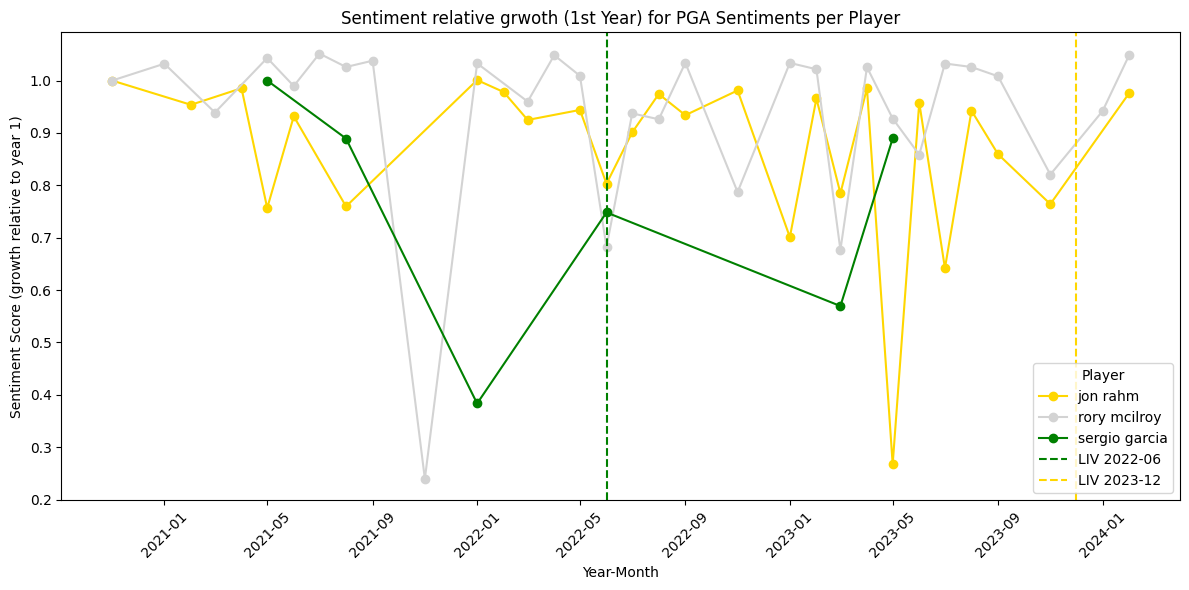

In [684]:
#liv_players = ['jon rahm', 'sergio garcia', 'phil mickelson', 'brooks koepka','dustin johnson', 'cameron smith']

#Defining Cohort 
groups = cohort1

df_pga_m = df_pga[df_pga['player'].isin(groups)][['player','year_month','relative_growth']]

# Define the player colors
player_colors = {'sergio garcia': 'green', 'cameron smith': 'orange', 'jon rahm': 'gold', 'phil mickelson': 'purple', 'dustin johnson': 'grey'}

# Plot the lines for each player
plt.figure(figsize=(12, 6))
for player, data in df_pga_m.groupby('player'):
    color = player_colors.get(player, 'lightgrey')  # Default color is blue if player not in player_colors
    plt.plot(data['year_month'], data['relative_growth'], marker='o', label=player, linestyle='-', color=color)

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Sentiment Score (growth relative to year 1)')
plt.title('Sentiment relative grwoth (1st Year) for PGA Sentiments per Player')

# Add vertical lines
#plt.axvline(x=pd.to_datetime('2022-08'), color='orange', linestyle='--', label='LIV 2022-08')
plt.axvline(x=pd.to_datetime('2022-06'), color='green', linestyle='--', label='LIV 2022-06')
plt.axvline(x=pd.to_datetime('2023-12'), color='gold', linestyle='--', label='LIV 2023-12')


# Show legend
plt.legend(title='Player', loc='lower right')

# Adjust plot settings
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


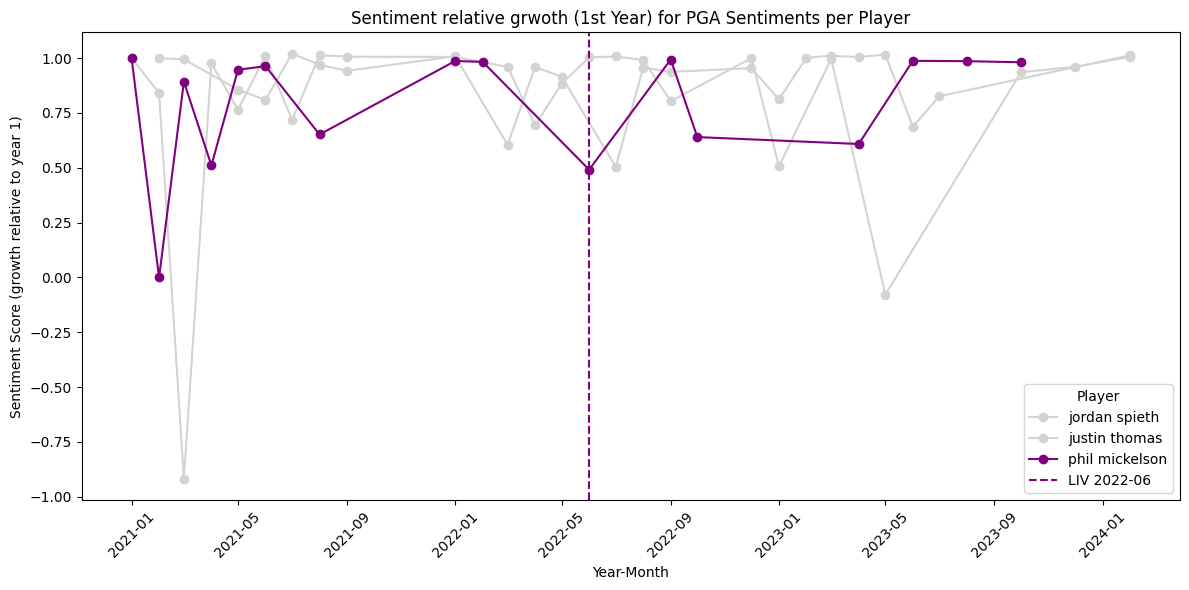

In [685]:
liv_players = ['jon rahm', 'sergio garcia', 'phil mickelson', 'brooks koepka','dustin johnson', 'cameron smith']

#Defining Cohort 
groups = cohort2

df_pga_m = df_pga[df_pga['player'].isin(groups)][['player','year_month','relative_growth']]

# Define the player colors
player_colors = {'sergio garcia': 'green', 'cameron smith': 'orange', 'jon rahm': 'lightgreen', 'phil mickelson': 'purple', 'dustin johnson': 'grey'}

# Plot the lines for each player
plt.figure(figsize=(12, 6))
for player, data in df_pga_m.groupby('player'):
    color = player_colors.get(player, 'lightgrey')  # Default color is blue if player not in player_colors
    plt.plot(data['year_month'], data['relative_growth'], marker='o', label=player, linestyle='-', color=color)

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Sentiment Score (growth relative to year 1)')
plt.title('Sentiment relative grwoth (1st Year) for PGA Sentiments per Player')

# Add vertical lines
plt.axvline(x=pd.to_datetime('2022-06'), color='purple', linestyle='--', label='LIV 2022-06')
#plt.axvline(x=pd.to_datetime('2022-06'), color='orange', linestyle='--', label='LIV 2022-08')
#plt.axvline(x=pd.to_datetime('2023-12'), color='orange', linestyle='--', label='LIV 2023-12')


# Show legend
plt.legend(title='Player', loc='lower right')

# Adjust plot settings
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


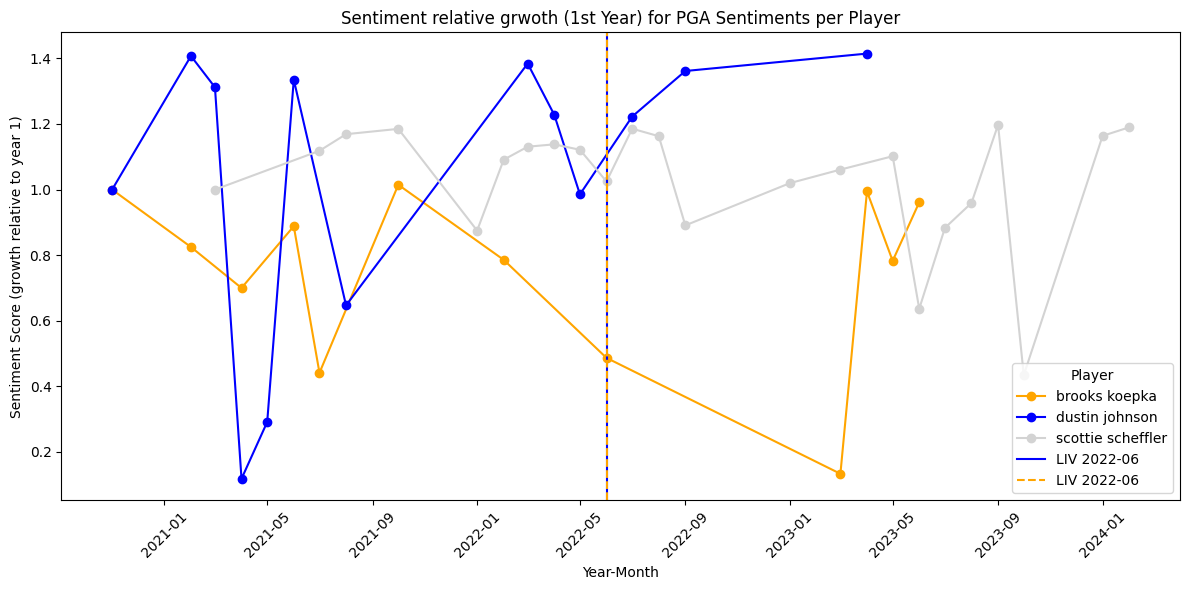

In [686]:
liv_players = ['jon rahm', 'sergio garcia', 'phil mickelson', 'brooks koepka','dustin johnson', 'cameron smith']

#Defining Cohort 
groups = cohort3

df_pga_m = df_pga[df_pga['player'].isin(groups)][['player','year_month','relative_growth']]

# Define the player colors
player_colors = {'sergio garcia': 'green', 'cameron smith': 'orange', 'jon rahm': 'lightgreen', 'phil mickelson': 'purple', 'dustin johnson': 'blue', 'brooks koepka':'orange'}

# Plot the lines for each player
plt.figure(figsize=(12, 6))
for player, data in df_pga_m.groupby('player'):
    color = player_colors.get(player, 'lightgrey')  # Default color is blue if player not in player_colors
    plt.plot(data['year_month'], data['relative_growth'], marker='o', label=player, linestyle='-', color=color)

# Set labels and title
plt.xlabel('Year-Month')
plt.ylabel('Sentiment Score (growth relative to year 1)')
plt.title('Sentiment relative grwoth (1st Year) for PGA Sentiments per Player')

# Add vertical lines
plt.axvline(x=pd.to_datetime('2022-06'), color='blue', linestyle='-', label='LIV 2022-06')
plt.axvline(x=pd.to_datetime('2022-06'), color='orange', linestyle='--', label='LIV 2022-06')
#plt.axvline(x=pd.to_datetime('2023-12'), color='orange', linestyle='--', label='LIV 2023-12')


# Show legend
plt.legend(title='Player', loc='lower right')

# Adjust plot settings
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


In [687]:
df_base = df_sent_month.groupby(['player', 'year_month'])['anwer_topic'].nunique().reset_index()
df_base['year_month'] = pd.to_datetime(df_base['year_month'], format='%Y-%m')
df_base

,player,year_month,anwer_topic
0,brooks koepka,2020-11-01,2
1,brooks koepka,2021-02-01,2
2,brooks koepka,2021-04-01,1
3,brooks koepka,2021-06-01,3
4,brooks koepka,2021-07-01,1
...,...,...,...
254,sergio garcia,2023-04-01,2
255,sergio garcia,2023-05-01,3
256,sergio garcia,2023-06-01,2
257,sergio garcia,2023-08-01,2


In [688]:
# Calculate lagged values
df_pga['lag1_sentiment'] = df_pga.groupby('player')['sentiment'].shift(1)
df_pga['lag2_sentiment'] = df_pga.groupby('player')['sentiment'].shift(2)
df_pga['lag3_sentiment'] = df_pga.groupby('player')['sentiment'].shift(3)

In [695]:
df_pga = df_pga.rename(columns={'player': 'player','year_month': 'year_month', 'sentiment': 'sent_pga',
                                'lag1_sentiment':'pga_lag1','lag2_sentiment':'pga_lag2','lag3_sentiment':'pga_lag3'})
df_pga['year_month'] = pd.to_datetime(df_pga['year_month'], format='%Y-%m')
df_pga.shape

(207, 10)

Creating Dataframes for LIV and Both sentiments to be merged with df_pga

In [696]:
df_liv = df_sent_month[df_sent_month['anwer_topic']=='liv'][['player','year_month','sentiment']]
df_liv = df_liv.rename(columns={'player': 'player','year_month': 'year_month', 'sentiment': 'sent_liv'})
df_liv['year_month'] = pd.to_datetime(df_liv['year_month'], format='%Y-%m')
df_liv.shape

(186, 3)

In [697]:
df_both = df_sent_month[df_sent_month['anwer_topic']=='both'][['player','year_month','sentiment']]
df_both = df_both.rename(columns={'player': 'player','year_month': 'year_month', 'sentiment': 'sent_both'})
df_both['year_month'] = pd.to_datetime(df_both['year_month'], format='%Y-%m')
df_both.shape

(83, 3)

### MERGING EVERYTHING

In [698]:
df_merge = df_base.merge(df_pga, how='left', on=['player','year_month']) \
                  .merge(df_liv, how='left', on=['player','year_month'])\
                  .merge(df_both, how='left', on=['player','year_month'])

df_merge

,player,year_month,anwer_topic,sent_pga,percentage_change,first_month,first_sentiment,relative_growth,pga_lag1,pga_lag2,pga_lag3,sent_liv,sent_both
0,brooks koepka,2020-11-01,2,0.958400,NaN,2020-11-01,0.95840,1.000000,NaN,NaN,NaN,0.651700,NaN
1,brooks koepka,2021-02-01,2,0.790600,-0.175083,2020-11-01,0.95840,0.824917,0.958400,NaN,NaN,0.839250,NaN
2,brooks koepka,2021-04-01,1,0.670867,-0.151446,2020-11-01,0.95840,0.699986,0.790600,0.958400,NaN,NaN,NaN
3,brooks koepka,2021-06-01,3,0.851413,0.269123,2020-11-01,0.95840,0.888369,0.670867,0.790600,0.9584,0.102600,0.96230
4,brooks koepka,2021-07-01,1,0.423000,-0.503179,2020-11-01,0.95840,0.441361,0.851413,0.670867,0.7906,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,sergio garcia,2023-04-01,2,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,0.607133,0.83260
255,sergio garcia,2023-05-01,3,0.870600,0.561895,2021-05-01,0.97875,0.889502,0.557400,0.732300,0.3753,0.992900,0.99065
256,sergio garcia,2023-06-01,2,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,0.517933,0.90610
257,sergio garcia,2023-08-01,2,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,0.970775,0.92170


In [700]:
df_merge_p = df_merge[['player','year_month','sent_pga','pga_lag1','pga_lag2','pga_lag3','sent_liv','sent_both']]

# List of players and their corresponding specific dates
players_and_dates = {
    'sergio garcia': pd.to_datetime('2022-06-01'),
    'dustin johnson': pd.to_datetime('2022-06-01'),
    'phil mickelson': pd.to_datetime('2022-06-01'),
    'ian poulter': pd.to_datetime('2022-06-01'),
    'talor gooch': pd.to_datetime('2022-06-01'),
    'cameron smith': pd.to_datetime('2022-08-01'),
    'joaquin niemann': pd.to_datetime('2022-09-01'),
    'bryson dechambeau': pd.to_datetime('2022-06-01'),
    'brooks koepka': pd.to_datetime('2022-06-01'),
    'jon rahm': pd.to_datetime('2023-12-01'),
    # Add more players and dates as needed
}

##Adding Target Variable
df_merge_p['LIV_CHANGE'] = df_merge_p.apply(lambda row: 1 if (row['player'].lower() in players_and_dates and row['year_month'] == players_and_dates[row['player'].lower()]) else 0, axis=1)

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_9495/796493710.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge_p['LIV_CHANGE'] = df_merge_p.apply(lambda row: 1 if (row['player'].lower() in players_and_dates and row['year_month'] == players_and_dates[row['player'].lower()]) else 0, axis=1)


In [705]:
df_merge_p.head(10)

,player,year_month,sent_pga,pga_lag1,pga_lag2,pga_lag3,sent_liv,sent_both,LIV_CHANGE
0,brooks koepka,2020-11-01,0.958400,NaN,NaN,NaN,0.65170,NaN,0
1,brooks koepka,2021-02-01,0.790600,0.958400,NaN,NaN,0.83925,NaN,0
2,brooks koepka,2021-04-01,0.670867,0.790600,0.958400,NaN,NaN,NaN,0
3,brooks koepka,2021-06-01,0.851413,0.670867,0.790600,0.958400,0.10260,0.9623,0
4,brooks koepka,2021-07-01,0.423000,0.851413,0.670867,0.790600,NaN,NaN,0
5,brooks koepka,2021-09-01,NaN,NaN,NaN,NaN,0.86580,NaN,0
6,brooks koepka,2021-10-01,0.972567,0.423000,0.851413,0.670867,0.63250,NaN,0
7,brooks koepka,2022-02-01,0.753200,0.972567,0.423000,0.851413,0.78875,NaN,0
8,brooks koepka,2022-06-01,0.466633,0.753200,0.972567,0.423000,0.89225,NaN,1
9,brooks koepka,2022-09-01,NaN,NaN,NaN,NaN,0.75790,NaN,0


In [704]:
## Generate CSV
# Define the file path where you want to save the CSV file
file_path = "/Users/mikelgallo/repos2/pga_liv/datasets/df_prediction.csv"

# Save the DataFrame as a CSV file
df_merge_p.to_csv(file_path, index=False)

print("DataFrame saved as CSV file successfully!")

DataFrame saved as CSV file successfully!
